# Capstone 2024 - Table Recognition Work

Dataset:
[PubTables-1m](https://huggingface.co/datasets/bsmock/pubtables-1m)

Model: 
[YoloV11](https://docs.ultralytics.com/models/yolo11/)

In [1]:
!wget https://huggingface.co/datasets/bsmock/pubtables-1m/resolve/main/PubTables-1M-Structure_Annotations_Val.tar.gz
!wget https://huggingface.co/datasets/bsmock/pubtables-1m/resolve/main/PubTables-1M-Structure_Images_Val.tar.gz

--2024-10-17 06:51:05--  https://huggingface.co/datasets/bsmock/pubtables-1m/resolve/main/PubTables-1M-Structure_Annotations_Val.tar.gz
Resolving huggingface.co (huggingface.co)... 108.156.201.48, 108.156.201.102, 108.156.201.58, ...
Connecting to huggingface.co (huggingface.co)|108.156.201.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/36/c0/36c021133128a16f57db86f4cb105c85b76fb8fb4968b96642a02b5140872630/6b8c4b512e24e1040fa0829935ab9c2d13fc0015f7315cc8f13ef82a8bc95ca4?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27PubTables-1M-Structure_Annotations_Val.tar.gz%3B+filename%3D%22PubTables-1M-Structure_Annotations_Val.tar.gz%22%3B&response-content-type=application%2Fgzip&Expires=1729407065&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyOTQwNzA2NX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy8zNi9jMC8zNmMwMjExMzMxMjhhMTZmNTdkYjg2ZjRjYjEwNWM4NWI3NmZiOGZiNDk2OG

In [2]:
!mkdir ./data
!mkdir ./data/PubTables-1M-Structure_Images_Val
!mkdir ./data/PubTables-1M-Structure_Annotations_Val
!tar -xf PubTables-1M-Structure_Images_Val.tar.gz -C ./data/PubTables-1M-Structure_Images_Val
!tar -xf PubTables-1M-Structure_Annotations_Val.tar.gz -C ./data/PubTables-1M-Structure_Annotations_Val

# Create YOLO Dataset

In [3]:
import os
import yaml
import shutil
import cv2
import random
import colorsys
import numpy as np

import xml.etree.ElementTree as ET

from glob import glob
from PIL import Image

import matplotlib.pyplot as plt

In [4]:
classes = [
    'table column',
#     'table row',
#     'table spanning cell',
#     'table text cell'
]

def convert_coordinates(size, box):
    dw, dh = 1.0/size[0], 1.0/size[1]
    xmin, ymin, xmax, ymax = box
    w, h = xmax - xmin, ymax - ymin
    x_center, y_center = xmin + w/2, ymin + h/2
    return (x_center * dw, y_center * dh, w * dw, h * dh)

def convert_xml_to_yolo_and_copy_image(xml_file_path, dest_labels_dir, source_images_dir, dest_images_dir):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    filename = root.find('filename').text
    image_path = os.path.join(source_images_dir, filename)
#     print(image_path)
    # Read image dimensions using PIL
    with Image.open(image_path) as img:
        width, height = img.size

    output_filename = os.path.splitext(filename)[0] + '.txt'
    with open(os.path.join(dest_labels_dir, output_filename), 'w') as out_file:
        for obj in root.iter('object'):
            cls = obj.find('name').text
            if cls not in classes:
                continue

            cls_id = classes.index(cls)

            xmlbox = obj.find('bndbox')
            xmin = float(xmlbox.find('xmin').text) / width
            ymin = float(xmlbox.find('ymin').text) / height
            xmax = float(xmlbox.find('xmax').text) / width
            ymax = float(xmlbox.find('ymax').text) / height
            
            # Create a polygon with 4 points (rectangle corners)
            points = [
                (xmin, ymin),  # Top-left
                (xmax, ymin),  # Top-right
                (xmax, ymax),  # Bottom-right
                (xmin, ymax)   # Bottom-left
            ]
            
            # Format the points as a string
            points_str = ' '.join([f'{x:.6f} {y:.6f}' for x, y in points])
            
            out_file.write(f"{cls_id} {points_str}\n")
    
    # Copy corresponding image to train directory
    base_name = os.path.splitext(os.path.basename(xml_file_path))[0]
    for ext in ['.jpg', '.jpeg', '.png', '.bmp']:
        image_file = os.path.join(data_images_dir, base_name + ext)
        if os.path.exists(image_file):
#             print("Copied", image_file, dest_images_dir)
            shutil.copy(image_file, dest_images_dir)
            break
    return

In [5]:
def create_dataset(
    data_images_dir, data_labels_dir, 
    train_images_dir, train_labels_dir,
    val_images_dir, val_labels_dir,
    number_of_samples=0, dataset_split_ratio = 0.8):

    xml_files = glob(os.path.join(data_labels_dir, '*.xml'))

    if number_of_samples:
        xml_files = xml_files[:number_of_samples]
    # Calculate the split index
    split_index = int(len(xml_files) * 0.8)  # Assuming 80% train, 20% val split

    # Split the files
    train_xml_files = xml_files[:split_index]
    val_xml_files = xml_files[split_index:]

    # Process train files
    for xml_file_path in train_xml_files:
        convert_xml_to_yolo_and_copy_image(xml_file_path, train_labels_dir, data_images_dir, train_images_dir)

    # Process validation files
    for xml_file_path in val_xml_files:
        convert_xml_to_yolo_and_copy_image(xml_file_path, val_labels_dir, data_images_dir, val_images_dir)

def create_dataset_yaml(dataset_dir, yaml_path):
  # Create the dataset structure
  dataset = {
      'path': os.path.abspath(dataset_dir),
      'train': 'train',  # Assuming all data is for training
      'val': 'val',    # Using same data for validation
    #   'test': 'train',   # Using same data for testing
      'names': {i: name for i, name in enumerate(classes)},
      'nc': len(classes)
  }

  # Write the YAML file
  with open(yaml_path, 'w') as file:
      yaml.dump(dataset, file, default_flow_style=False)

  print(f"Dataset YAML file created at: {yaml_path}")

In [6]:
data_dir = "/kaggle/working/data"
data_images_dir = "/kaggle/working/data/PubTables-1M-Structure_Images_Val"
data_labels_dir = "/kaggle/working/data/PubTables-1M-Structure_Annotations_Val"

dataset_dir = "/kaggle/working/dataset"
train_images_dir = os.path.join(dataset_dir, "train", "images")
train_labels_dir = os.path.join(dataset_dir, "train", "labels")
val_images_dir = os.path.join(dataset_dir, "val", "images")
val_labels_dir = os.path.join(dataset_dir, "val", "labels")

dataset_yaml_path = "/kaggle/working/dataset/dataset.yaml"

os.makedirs(dataset_dir, exist_ok=True)
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)

number_of_samples = 5000
dataset_split_ratio = 0.8

create_dataset(
    data_images_dir, data_labels_dir, 
    train_images_dir, train_labels_dir,
    val_images_dir, val_labels_dir,
    number_of_samples,
    dataset_split_ratio
)
create_dataset_yaml(dataset_dir, dataset_yaml_path)

Dataset YAML file created at: /kaggle/working/dataset/dataset.yaml


In [7]:
# !rm -rf "/kaggle/working/dataset"

# Data sample visualization

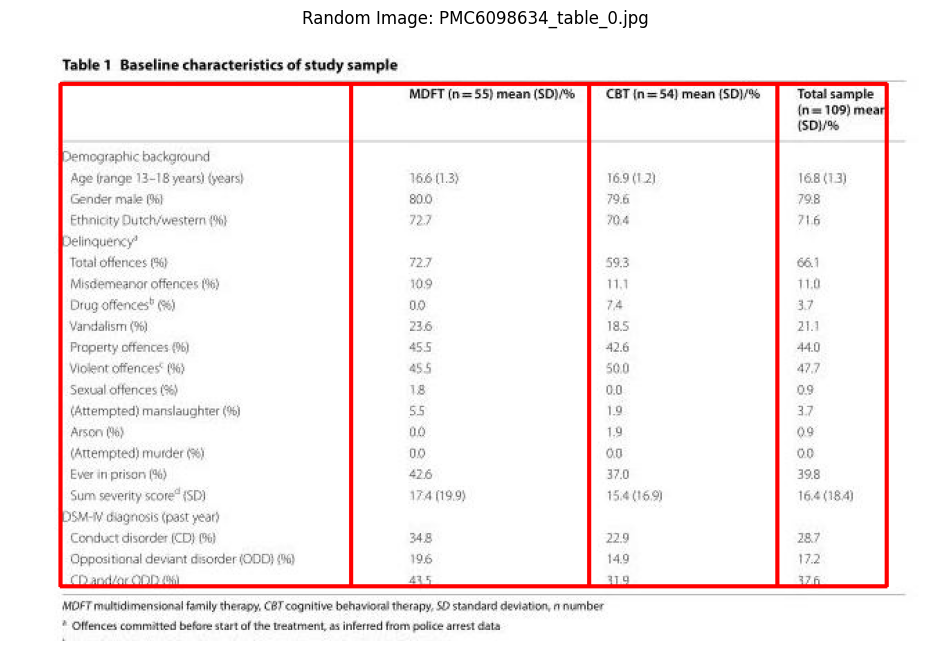

In [8]:
# Load the dataset configuration
with open(dataset_yaml_path, 'r') as file:
    dataset_config = yaml.safe_load(file)

# Get the dataset path and class names
dataset_path = dataset_config['path']
class_names = dataset_config['names']

# Choose a random set (train or val)
image_set = random.choice(['train', 'val'])
images_path = os.path.join(dataset_path, image_set, 'images')
# Get a list of all image files
image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Choose a random image
random_image = random.choice(image_files)
image_path = os.path.join(images_path, random_image)

# Load the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Load the corresponding label file
label_path = os.path.join(dataset_path, image_set, 'labels', random_image.rsplit('.', 1)[0] + '.txt')

# Read and parse the label file
with open(label_path, 'r') as file:
    labels = file.readlines()

# Get image dimensions
height, width, _ = image.shape

# Function to generate distinct colors
def generate_colors(n):
    hsv_tuples = [(x / n, 1., 1.) for x in range(n)]
    return list(map(lambda x: tuple(round(i * 255) for i in colorsys.hsv_to_rgb(*x)), hsv_tuples))

# Generate a color for each class
colors = generate_colors(len(class_names))

# Draw bounding boxes and labels
for label in labels:
    class_id, *points = map(float, label.strip().split())
    
    # Convert normalized coordinates to pixel coordinates
    pixel_points = [(int(x * width), int(y * height)) for x, y in zip(points[::2], points[1::2])]
    
    # Get color for this class
    color = colors[int(class_id)]
    
    # Draw polygon
    cv2.polylines(image, [np.array(pixel_points)], isClosed=True, color=color, thickness=2)

    # Add label
    class_name = class_names[int(class_id)]
    # cv2.putText(image, class_name, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

# Display the image
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off')
plt.title(f"Random Image: {random_image}")
plt.show()

In [9]:
labels

['0 0.054598 0.084555 0.366278 0.084555 0.366278 0.911227 0.054598 0.911227\n',
 '0 0.366278 0.084555 0.622875 0.084555 0.622875 0.911227 0.366278 0.911227\n',
 '0 0.622875 0.084555 0.825072 0.084555 0.825072 0.911227 0.622875 0.911227\n',
 '0 0.825072 0.084555 0.942428 0.084555 0.942428 0.911227 0.825072 0.911227\n']

In [10]:
!rm -rf "/kaggle/working/data"
!rm -rf "/kaggle/working/*.tar"
!rm -rf "/kaggle/working/*.gz"

# Model training

In [11]:
!pip install --no-cache-dir ultralytics
!pip install -U ipywidgets
os.environ['WANDB_DISABLED'] = 'true'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 870.5/870.5 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 47.8 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully uninstalled widgetsnbextension-3.6.9
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab_widgets 3.0.11
    Uninstalling jupyterlab_widgets-3.0.11:
      Successfully uninstalled jupyterlab_widgets-3.0.11
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This

In [12]:
from ultralytics import YOLO
model = YOLO("yolo11m-seg.pt")
model.train(
    data=dataset_yaml_path,
    epochs=100,
    device="cuda",
    translate=0.2,
    scale=0.7,
    flipud=0.0,
    erasing=0.2
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 43.3M/43.3M [00:00<00:00, 260MB/s]


Ultralytics 8.3.15 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset/dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

100%|██████████| 755k/755k [00:00<00:00, 15.1MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Tracking run with wandb version 0.18.3
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLO11n...


100%|██████████| 5.35M/5.35M [00:00<00:00, 66.1MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/dataset/train/labels... 4000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:04<00:00, 877.06it/s]


train: New cache created: /kaggle/working/dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/dataset/val/labels... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:01<00:00, 724.60it/s]


val: New cache created: /kaggle/working/dataset/val/labels.cache
Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      10.6G      1.229      1.215     0.9384      1.266        178        640: 100%|██████████| 250/250 [03:17<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]


                   all       1000       5469      0.788      0.851      0.857      0.488      0.788      0.851      0.856        0.5

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      10.6G      1.035     0.7838     0.7194      1.152        180        640: 100%|██████████| 250/250 [03:16<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]

                   all       1000       5469      0.755      0.868      0.878      0.664      0.749      0.866      0.873        0.6



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      10.6G     0.9524     0.7255     0.6453      1.105        265        640: 100%|██████████| 250/250 [03:14<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]

                   all       1000       5469      0.917      0.944      0.967      0.719      0.915      0.941      0.963      0.671



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      10.6G     0.8645     0.6943     0.5749      1.064        230        640: 100%|██████████| 250/250 [03:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]


                   all       1000       5469      0.867      0.892      0.924      0.611      0.867      0.891      0.923      0.591

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      10.5G     0.8059      0.653      0.538      1.042        139        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]

                   all       1000       5469      0.825      0.712      0.787      0.552      0.823      0.711      0.785      0.522



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      10.5G     0.7646     0.6218     0.5047      1.022        203        640: 100%|██████████| 250/250 [03:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]

                   all       1000       5469      0.119       0.04     0.0264      0.013      0.117       0.04     0.0268     0.0123



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      10.5G     0.7162     0.5929     0.4636     0.9964        193        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]

                   all       1000       5469       0.96      0.952      0.982      0.847      0.961       0.95      0.981      0.814



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      10.7G     0.6935     0.5833     0.4441     0.9879        180        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]

                   all       1000       5469      0.681       0.56       0.63      0.401      0.677      0.557      0.627      0.384



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      10.5G     0.6745     0.5774     0.4356     0.9809        226        640: 100%|██████████| 250/250 [03:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]

                   all       1000       5469       0.57      0.134      0.157     0.0863      0.565      0.133      0.158     0.0819



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      10.6G     0.6586     0.5614     0.4288     0.9765        171        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]

                   all       1000       5469      0.976      0.983       0.99      0.891      0.976      0.983       0.99      0.832



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      10.6G     0.6411     0.5466     0.4163     0.9688        161        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]

                   all       1000       5469     0.0793     0.0371     0.0255     0.0121     0.0793     0.0371      0.026     0.0111



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      10.5G     0.6344     0.5526     0.4082     0.9662        201        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]

                   all       1000       5469      0.751      0.596      0.693      0.482      0.745      0.593      0.687       0.45



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      10.6G      0.619      0.547     0.3939     0.9502        177        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]

                   all       1000       5469      0.982       0.98      0.993      0.901       0.98      0.978      0.992      0.818



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      10.7G     0.5973     0.5311     0.3886     0.9473        177        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]

                   all       1000       5469      0.988       0.98      0.993      0.925      0.986      0.981      0.993      0.849



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      10.5G     0.5879     0.5138     0.3811     0.9457        201        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]

                   all       1000       5469      0.925      0.898      0.946      0.783      0.923      0.896      0.944      0.728



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      10.7G     0.5808      0.506     0.3739     0.9389        175        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]

                   all       1000       5469      0.979      0.983      0.992      0.917      0.978      0.982      0.992      0.835



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      10.6G     0.5746     0.4886     0.3716     0.9376        198        640: 100%|██████████| 250/250 [03:12<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]

                   all       1000       5469      0.974       0.97      0.991      0.908      0.974      0.969      0.991       0.83



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      10.6G     0.5615     0.5037     0.3602     0.9298        216        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]

                   all       1000       5469      0.818      0.649      0.757      0.579      0.815      0.642       0.75      0.544



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      10.6G     0.5632      0.511     0.3597     0.9289        213        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]

                   all       1000       5469      0.984       0.99      0.993      0.937      0.983       0.99      0.993      0.867



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      10.6G     0.5503     0.4907     0.3513     0.9292        260        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]

                   all       1000       5469     0.0561      0.131     0.0425     0.0162     0.0571      0.133     0.0433     0.0158



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      10.5G      0.545     0.4907     0.3511     0.9259        163        640: 100%|██████████| 250/250 [03:12<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]

                   all       1000       5469      0.986      0.982      0.993      0.926      0.983      0.983      0.993      0.856



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      10.6G     0.5389     0.4835     0.3429      0.926        166        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]

                   all       1000       5469       0.98      0.981      0.993      0.923      0.982      0.977      0.993      0.845



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      10.5G     0.5239     0.4704     0.3377     0.9204        205        640: 100%|██████████| 250/250 [03:12<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]

                   all       1000       5469      0.985      0.988      0.993      0.944      0.984      0.987      0.993      0.863



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      10.5G     0.5255     0.4802     0.3393     0.9197        221        640: 100%|██████████| 250/250 [03:12<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]

                   all       1000       5469      0.878      0.803      0.888      0.684      0.883      0.798      0.887      0.646



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      10.6G     0.5268     0.4692     0.3412     0.9216        221        640: 100%|██████████| 250/250 [03:12<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]

                   all       1000       5469      0.985      0.988      0.993      0.944      0.985      0.987      0.992      0.861



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      10.4G     0.5197     0.4696     0.3344     0.9201        210        640: 100%|██████████| 250/250 [03:12<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]

                   all       1000       5469      0.991       0.99      0.993      0.945      0.991      0.988      0.993      0.869



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      10.5G     0.5055     0.4609     0.3299      0.909        203        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]

                   all       1000       5469      0.989      0.993      0.994      0.954      0.989      0.992      0.993      0.874



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      10.5G     0.5016     0.4524     0.3244     0.9123        176        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]

                   all       1000       5469      0.832      0.701      0.795      0.597      0.829      0.698      0.793      0.554



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      10.6G     0.4991       0.46     0.3198     0.9051        154        640: 100%|██████████| 250/250 [03:12<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]

                   all       1000       5469      0.988      0.994      0.994      0.957      0.988      0.994      0.994      0.879



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      10.6G     0.5007     0.4589     0.3248     0.9132        213        640: 100%|██████████| 250/250 [03:12<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]

                   all       1000       5469      0.989      0.985      0.994      0.948      0.988      0.985      0.993      0.879



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      10.6G     0.5042     0.4486     0.3256     0.9147        189        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]

                   all       1000       5469      0.984      0.984      0.991       0.94      0.983      0.984      0.991      0.874



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      10.5G     0.4876     0.4471     0.3129     0.8987        164        640: 100%|██████████| 250/250 [03:12<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]

                   all       1000       5469      0.991      0.993      0.994      0.961       0.99      0.992      0.993      0.879



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      10.5G     0.4835     0.4417     0.3104     0.9032        181        640: 100%|██████████| 250/250 [03:13<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]

                   all       1000       5469       0.99      0.991      0.994      0.962       0.99      0.989      0.994      0.888



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      10.6G     0.4928     0.4415     0.3132      0.906        236        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]

                   all       1000       5469      0.978      0.972       0.99      0.882      0.977       0.97      0.989      0.806



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      10.6G      0.486     0.4506     0.3089     0.9014        233        640: 100%|██████████| 250/250 [03:12<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]

                   all       1000       5469       0.99      0.989      0.994      0.955      0.989      0.987      0.993      0.884



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      10.5G     0.4775     0.4511     0.3032     0.9005        219        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]

                   all       1000       5469       0.99      0.995      0.994      0.958       0.99      0.994      0.994       0.89



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      10.6G      0.475     0.4441     0.3066     0.8979        166        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]

                   all       1000       5469      0.995      0.991      0.994      0.959      0.994       0.99      0.994      0.884



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      10.6G     0.4692     0.4314     0.2985     0.8973        223        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]

                   all       1000       5469      0.989      0.995      0.994      0.963      0.989      0.994      0.994      0.884



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      10.6G     0.4612     0.4347     0.2987     0.8919        182        640: 100%|██████████| 250/250 [03:12<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]

                   all       1000       5469      0.991      0.993      0.993      0.957       0.99      0.993      0.993      0.884



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      10.6G     0.4622     0.4346     0.2958     0.8942        191        640: 100%|██████████| 250/250 [03:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]

                   all       1000       5469      0.992      0.995      0.994      0.967      0.991      0.995      0.993      0.894



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      10.6G     0.4569     0.4235     0.2923     0.8995        166        640: 100%|██████████| 250/250 [03:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]

                   all       1000       5469       0.99      0.993      0.994      0.959      0.993      0.989      0.994      0.886



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      10.7G     0.4619     0.4219     0.2964     0.8941        168        640: 100%|██████████| 250/250 [03:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]

                   all       1000       5469      0.993      0.992      0.993       0.96      0.993      0.993      0.993      0.887



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      10.5G     0.4519     0.4274     0.2908     0.8899        184        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]

                   all       1000       5469      0.989      0.995      0.994       0.96      0.989      0.994      0.994      0.883



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      10.7G     0.4423     0.4115     0.2847       0.89        195        640: 100%|██████████| 250/250 [03:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]

                   all       1000       5469       0.99      0.993      0.993      0.966       0.99      0.992      0.993      0.886



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      10.6G     0.4473     0.4144     0.2892     0.8878        234        640: 100%|██████████| 250/250 [03:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]

                   all       1000       5469      0.992      0.992      0.994      0.964      0.992      0.991      0.994      0.894



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      10.6G     0.4361     0.4108     0.2799     0.8892        199        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]

                   all       1000       5469      0.993      0.997      0.994      0.973      0.992      0.996      0.994        0.9



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      10.5G      0.425     0.4049       0.28     0.8868        168        640: 100%|██████████| 250/250 [03:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]

                   all       1000       5469      0.991      0.992      0.994      0.966       0.99      0.991      0.994      0.884



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      10.6G     0.4311     0.4094      0.281     0.8875        214        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]

                   all       1000       5469      0.992      0.997      0.994      0.973      0.991      0.996      0.994      0.893



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      10.5G     0.4325      0.417     0.2837     0.8892        208        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]

                   all       1000       5469      0.995      0.995      0.994      0.972      0.995      0.995      0.994      0.894



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      10.4G     0.4179     0.3997     0.2738     0.8821        217        640: 100%|██████████| 250/250 [03:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]

                   all       1000       5469      0.987      0.989      0.993      0.966      0.986      0.989      0.993      0.893



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      10.6G     0.4167     0.3989     0.2736     0.8803        172        640: 100%|██████████| 250/250 [03:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]

                   all       1000       5469      0.992      0.995      0.994      0.975      0.992      0.995      0.994      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      10.6G     0.4094      0.389       0.27     0.8769        170        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]

                   all       1000       5469      0.991      0.995      0.993      0.975      0.991      0.994      0.993      0.902



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      10.6G     0.3993     0.3842     0.2618      0.876        146        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]

                   all       1000       5469      0.994      0.993      0.994      0.978      0.993      0.993      0.994      0.903



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      10.6G     0.4034     0.3813     0.2644     0.8813        225        640: 100%|██████████| 250/250 [03:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]

                   all       1000       5469      0.996      0.997      0.994      0.977      0.996      0.995      0.994      0.897



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      10.6G     0.4074     0.3851     0.2665     0.8864        198        640: 100%|██████████| 250/250 [03:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]

                   all       1000       5469      0.995      0.995      0.994      0.979      0.995      0.995      0.994      0.902



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      10.6G     0.4009     0.3793     0.2642     0.8792        231        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]

                   all       1000       5469      0.995      0.996      0.994      0.977      0.994      0.996      0.994      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      10.5G      0.399     0.3816     0.2607     0.8782        147        640: 100%|██████████| 250/250 [03:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]

                   all       1000       5469      0.994      0.996      0.994      0.978      0.994      0.996      0.994      0.904



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      10.6G     0.3953     0.3777     0.2597      0.879        190        640: 100%|██████████| 250/250 [03:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]

                   all       1000       5469      0.992      0.998      0.994       0.98      0.992      0.997      0.994      0.902



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      10.6G     0.3916     0.3739       0.26     0.8804        220        640: 100%|██████████| 250/250 [03:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]

                   all       1000       5469      0.995      0.996      0.994       0.98      0.995      0.996      0.994      0.912



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      10.6G      0.388     0.3755     0.2545     0.8776        185        640: 100%|██████████| 250/250 [03:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]

                   all       1000       5469      0.993      0.994      0.994       0.98      0.993      0.994      0.994      0.906



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      10.5G     0.3842     0.3747     0.2529     0.8752        203        640: 100%|██████████| 250/250 [03:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]

                   all       1000       5469       0.99      0.994      0.993       0.98       0.99      0.994      0.993      0.906



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      10.6G     0.3776     0.3695      0.249      0.874        160        640: 100%|██████████| 250/250 [03:14<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]

                   all       1000       5469      0.992      0.997      0.994      0.982      0.992      0.996      0.994      0.908



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      10.5G     0.3828     0.3767     0.2516     0.8743        241        640: 100%|██████████| 250/250 [03:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]

                   all       1000       5469      0.994      0.997      0.994      0.982      0.994      0.997      0.994       0.91



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      10.5G     0.3728     0.3562     0.2471     0.8679        191        640: 100%|██████████| 250/250 [03:14<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]

                   all       1000       5469      0.994      0.998      0.994      0.983      0.994      0.998      0.994      0.911



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      10.4G      0.368     0.3621     0.2423     0.8725        186        640: 100%|██████████| 250/250 [03:15<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]

                   all       1000       5469      0.992      0.994      0.994      0.982      0.992      0.994      0.994      0.916



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      10.5G     0.3698     0.3608     0.2446     0.8703        162        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]

                   all       1000       5469      0.992      0.997      0.994      0.983      0.991      0.996      0.994      0.911



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      10.4G     0.3674     0.3563     0.2437     0.8727        160        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]

                   all       1000       5469      0.992      0.994      0.993      0.978      0.992      0.994      0.993      0.905



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      10.5G     0.3634     0.3504     0.2419     0.8711        184        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]

                   all       1000       5469      0.992      0.997      0.994      0.982      0.991      0.996      0.993      0.911



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      10.6G     0.3688     0.3537      0.243     0.8716        170        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]

                   all       1000       5469      0.994      0.997      0.994      0.981      0.994      0.996      0.994      0.911



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      10.5G     0.3642     0.3533     0.2395     0.8705        192        640: 100%|██████████| 250/250 [03:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]

                   all       1000       5469      0.995      0.996      0.994      0.983      0.995      0.996      0.994      0.913



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      10.5G     0.3598     0.3442     0.2358     0.8682        124        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]

                   all       1000       5469      0.996      0.994      0.994      0.982      0.995      0.994      0.994      0.906



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      10.5G     0.3591     0.3522     0.2343     0.8677        208        640: 100%|██████████| 250/250 [03:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]

                   all       1000       5469      0.995      0.997      0.994      0.984      0.994      0.997      0.994      0.913



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      10.5G     0.3536     0.3373     0.2322     0.8664        215        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]

                   all       1000       5469      0.992      0.997      0.994      0.983      0.992      0.995      0.994      0.906



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      10.5G     0.3533     0.3476     0.2345     0.8663        187        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]

                   all       1000       5469      0.995      0.996      0.994      0.981      0.994      0.995      0.993      0.908



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      10.5G     0.3538     0.3403     0.2335     0.8674        175        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]

                   all       1000       5469      0.994      0.998      0.994      0.984      0.994      0.998      0.994      0.911



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      10.7G     0.3455     0.3414     0.2286     0.8647        231        640: 100%|██████████| 250/250 [03:14<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]

                   all       1000       5469      0.996      0.997      0.994      0.984      0.995      0.997      0.994      0.911



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      10.6G     0.3427     0.3388     0.2291     0.8615        184        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]

                   all       1000       5469      0.995      0.997      0.994      0.983      0.995      0.997      0.994      0.915



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      10.6G     0.3417     0.3313     0.2247     0.8649        166        640: 100%|██████████| 250/250 [03:14<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]

                   all       1000       5469      0.995      0.996      0.994      0.985      0.995      0.996      0.994      0.915



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      10.5G     0.3416     0.3343     0.2264      0.863        241        640: 100%|██████████| 250/250 [03:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]

                   all       1000       5469      0.993      0.997      0.994      0.985      0.993      0.997      0.994      0.918



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      10.6G     0.3395     0.3321     0.2255     0.8619        217        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]

                   all       1000       5469      0.995      0.997      0.994      0.985      0.995      0.997      0.994      0.915



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      10.5G     0.3372     0.3225     0.2202     0.8622        219        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]

                   all       1000       5469      0.997      0.997      0.995      0.985      0.996      0.996      0.994      0.917



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      10.8G      0.331     0.3231      0.217     0.8582        214        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]

                   all       1000       5469      0.996      0.996      0.994      0.986      0.995      0.995      0.994      0.917



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      10.6G      0.336     0.3293     0.2206     0.8609        198        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]

                   all       1000       5469      0.996      0.998      0.994      0.986      0.995      0.997      0.994      0.916



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      10.4G     0.3234     0.3126      0.216     0.8559        154        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]

                   all       1000       5469      0.995      0.997      0.994      0.986      0.994      0.997      0.994      0.917



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      10.6G     0.3308     0.3219     0.2185     0.8559        218        640: 100%|██████████| 250/250 [03:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]

                   all       1000       5469      0.996      0.996      0.994      0.982      0.995      0.995      0.994      0.913



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      10.4G     0.3259       0.32     0.2153     0.8576        221        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]

                   all       1000       5469      0.996      0.997      0.994      0.986      0.996      0.997      0.994      0.917



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      10.7G     0.3242     0.3171     0.2123     0.8595        200        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]

                   all       1000       5469      0.996      0.998      0.994      0.986      0.995      0.997      0.994      0.917



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      10.6G     0.3249     0.3144     0.2137     0.8579        146        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]

                   all       1000       5469      0.997      0.996      0.994      0.985      0.997      0.996      0.994      0.917



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      10.7G     0.3189     0.3158     0.2098     0.8561        175        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]

                   all       1000       5469      0.994      0.998      0.994      0.986      0.994      0.998      0.994      0.917



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100      10.6G     0.3182     0.3078     0.2084     0.8576        207        640: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]

                   all       1000       5469      0.995      0.998      0.994      0.987      0.995      0.996      0.994      0.918


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      10.3G     0.2419       0.27     0.1685     0.8147         84        640: 100%|██████████| 250/250 [03:06<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]

                   all       1000       5469      0.997      0.996      0.994      0.985      0.996      0.996      0.994      0.913



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100      10.3G     0.2346     0.2595     0.1611     0.8136         94        640: 100%|██████████| 250/250 [03:05<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]

                   all       1000       5469      0.996      0.999      0.994      0.985      0.995      0.998      0.994      0.918



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      10.3G     0.2262      0.265     0.1575     0.8128         74        640: 100%|██████████| 250/250 [03:05<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]

                   all       1000       5469      0.996      0.999      0.994      0.987      0.995      0.998      0.994      0.919



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      10.3G     0.2271     0.2527     0.1558     0.8082         87        640: 100%|██████████| 250/250 [03:05<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]

                   all       1000       5469      0.997      0.998      0.994      0.988      0.996      0.997      0.994      0.923



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      10.3G      0.226     0.2595     0.1567       0.81         90        640: 100%|██████████| 250/250 [03:05<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]

                   all       1000       5469      0.997      0.998      0.994      0.988      0.996      0.997      0.994      0.922



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100      10.4G      0.221     0.2598     0.1514     0.8075        101        640: 100%|██████████| 250/250 [03:05<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]

                   all       1000       5469      0.998      0.998      0.994      0.987      0.997      0.997      0.994       0.92



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      10.3G     0.2183     0.2455     0.1518     0.8076         91        640: 100%|██████████| 250/250 [03:05<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]

                   all       1000       5469      0.996      0.999      0.994      0.988      0.996      0.998      0.994      0.924



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      10.3G     0.2105     0.2417     0.1469     0.8055         94        640: 100%|██████████| 250/250 [03:05<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]

                   all       1000       5469      0.998      0.998      0.994      0.988      0.997      0.997      0.994      0.924



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100      10.3G     0.2122     0.2412     0.1466     0.8114         71        640: 100%|██████████| 250/250 [03:05<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]

                   all       1000       5469      0.997      0.998      0.994      0.987      0.997      0.998      0.994      0.924



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      10.4G     0.2151     0.2427     0.1479     0.8097         97        640: 100%|██████████| 250/250 [03:05<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]

                   all       1000       5469      0.997      0.998      0.994      0.988      0.996      0.998      0.994      0.924



100 epochs completed in 5.819 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 45.1MB
Optimizer stripped from runs/segment/train/weights/best.pt, 45.1MB

Validating runs/segment/train/weights/best.pt...
Ultralytics 8.3.15 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m-seg summary (fused): 330 layers, 22,336,083 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]


                   all       1000       5469      0.998      0.998      0.994      0.988      0.997      0.997      0.994      0.924
Speed: 0.1ms preprocess, 7.8ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▆███▇▇▇▇▇▇▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
wandb:                  lr/pg1 ▃████▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg2 █████▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▁▁▁
wandb:        metrics/mAP50(B) ▇▆▁▁█▆▁█████████████████████████████████
wandb:        metrics/mAP50(M) ▇▇▆▁▅▁▆████▇████████████████████████████
wandb:     metrics/mAP50-95(B) ▆▅▇▁▇▁████████▇█████████████████████████
wandb:     metrics/mAP50-95(M) ▅▆▆▅▁▇▇▅▁▇▆█▅███████████████████████████
wandb:    metrics/precision(B) ▆▁██▇▁███▇██████████████████████████████
wandb:    metrics/precision(M) ▇▁█▆▅█▇▁▇███████████████████████████████
wandb:       metrics/recall(B) ▁▅▅█▇█▂██████▆██████████████████████████
wandb:       metrics/recall(M) █▇█▄▇▁███▆██████████████████████████████
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c3311cbadd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 

# Model testing


0: 640x640 4 table columns, 57.3ms
Speed: 3.1ms preprocess, 57.3ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)


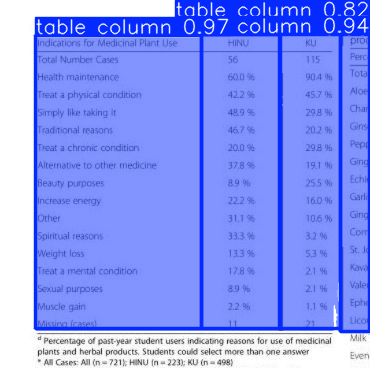

In [13]:
# Load the dataset configuration
with open(r"/kaggle/working/dataset/dataset.yaml", 'r') as file:
    dataset_config = yaml.safe_load(file)

# Get the dataset path and class names
dataset_path = dataset_config['path']
class_names = dataset_config['names']

# Choose a random set (train or val)
image_set = random.choice(['train', 'val'])
images_path = os.path.join(dataset_path, image_set, 'images')

# Get a list of all image files
image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Choose a random image
random_image = random.choice(image_files)
image_path = os.path.join(images_path, random_image)

# Run batched inference on a list of images
results = model([image_path])  # return a list of Results objects

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    result.save(filename="result.jpg")  # save to disk

# Model export

In [14]:
model.export(format="onnx", dynamic=True)

Ultralytics 8.3.15 🚀 Python-3.10.14 torch-2.4.0 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/segment/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 37, 8400), (1, 32, 160, 160)) (43.1 MB)
requirements: Ultralytics requirements ['onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.2/226.2 MB 232.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 204.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 236.4 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 18.3s, installed 2 packages: ['onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.35...
ONNX: export success ✅ 58.0s, saved as 'runs/segment/train/weights/b

'runs/segment/train/weights/best.onnx'